In [1]:
import os
import sys
sys.path.append(os.path.join('..', 'src'))

import pickle
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent import futures

from collaborative_filtering.item_based import ItemBased

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

### Load Data

In [2]:
DATA_DIR = os.path.join('..', 'data', 'processed', 'filtering')

In [3]:
with open(os.path.join(DATA_DIR, 'item_to_users.pickle'), 'rb') as file:
    item_to_users = pickle.load(file)

with open(os.path.join(DATA_DIR, 'train_ratings.pickle'), 'rb') as file:
    train_ratings = pickle.load(file)

with open(os.path.join(DATA_DIR, 'test_ratings.pickle'), 'rb') as file:
    test_ratings = pickle.load(file)

In [4]:
# get number of users and items
M = 1 + max(
    max([i[0] for i in train_ratings.keys()]),
    max([i[0] for i in test_ratings.keys()])
)
N = 1 + max(
    max([i[1] for i in train_ratings.keys()]),
    max([i[1] for i in test_ratings.keys()])
)
M, N

(9166, 1998)

### Fit model

In [12]:
MIN_NEIGHBORS = 1
MAX_NEIGHBORS = 120
STEP = 2
TRIALS = MAX_NEIGHBORS - MIN_NEIGHBORS + 1
N_WORKERS = 12

In [13]:
def parallel_fit(min_neighbors, max_neighbors, step=STEP):
    train_scores, test_scores = [], []
    for neighbors in range(min_neighbors, max_neighbors, step):
        ibcf = ItemBased(M, N, neighbors=neighbors)
        ibcf.fit(train_ratings, item_to_users)
        train_scores.append(ibcf.score(train_ratings))
        test_scores.append(ibcf.score(test_ratings))        
    return train_scores, test_scores

In [14]:
pool = futures.ProcessPoolExecutor(N_WORKERS)

fs = [
    pool.submit(parallel_fit, i * TRIALS // N_WORKERS + 1, (i + 1) * TRIALS // N_WORKERS + 1) for i in range(N_WORKERS)
]
futures.wait(fs)
result = [f.result() for f in fs]

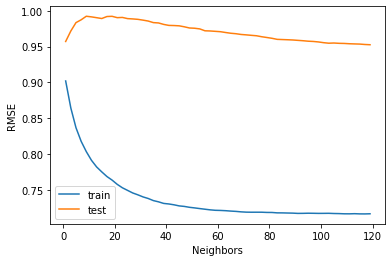

In [17]:
train_loss = np.concatenate([lst[0] for lst in result])
test_loss = np.concatenate([lst[1] for lst in result])
plt.plot(np.arange(MIN_NEIGHBORS, MAX_NEIGHBORS + 1, STEP), train_loss)
plt.plot(np.arange(MIN_NEIGHBORS, MAX_NEIGHBORS + 1, STEP), test_loss)
plt.legend(['train', 'test'])
plt.xlabel('Neighbors')
plt.ylabel('RMSE');